<a href="https://colab.research.google.com/github/Yarida-nes/weatherwise-Yarida-Kaewthong/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [11]:
# 🧪 Optional packages — uncomment if needed in Colab or JupyterHub
!pip install fetch-my-weather
!pip install hands-on-ai
!pip install PyInputPlus
!pip install requests
!pip install matplotlib

In [26]:
import os

os.environ['HANDS_ON_AI_SERVER'] = 'http://ollama.serveur.au'
os.environ['HANDS_ON_AI_MODEL'] = 'granite3.2'
os.environ['HANDS_ON_AI_API_KEY'] = input('Enter your API key: ')

Enter your API key: Perth


## 📦 Setup and Configuration
Import required packages and setup environment.

In [12]:
import requests
import matplotlib.pyplot as plt
# Install pyinputplus if not already installed
!pip install pyinputplus
import pyinputplus as pyip
# ✅ Import after installing (if needed)
from fetch_my_weather import get_weather
from hands_on_ai.chat import get_response

# Add any other setup code here

In [13]:
# Core libraries
import os
import re
from typing import Dict, Any, List, Optional, Tuple, Union
import requests
import matplotlib.pyplot as plt

# pyinputplus is preferred for menus, but guard if missing in some environments
try:
    import pyinputplus as pyip
except Exception:
    pyip = None  # UI cell will handle None gracefully

# Fetch weather via the teaching helper library
try:
    import fetch_my_weather as fmw
except Exception as e:
    fmw = None
    print("Warning: fetch_my_weather not installed. You can install it in Colab by running the optional pip cell above.")

# Global state used by UI/demo (kept minimal)
_LAST_LOCATION: Optional[str] = None
_LAST_FORECAST_DAYS: int = 5
_LAST_WEATHER: Optional[Dict[str, Any]] = None

# Helper for safe matplotlib usage in notebooks
plt.rcParams.update({
    "figure.figsize": (8, 4),
    "axes.grid": True
})

In [28]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## 🌤️ Weather Data Functions

In [14]:
# Define get_weather_data() function here

from fetch_my_weather import get_weather

def get_weather_data(location, forecast_days=5):
    """
    Retrieve weather data for a specified location.

    Args:
        location (str): City or location name
        forecast_days (int): Number of days to forecast (1-5)

    Returns:
        dict: Weather data including current conditions and forecast
    """
    try:
        data = get_weather(location)  # fetch data

        # Handle case where no data is returned or there's an error from fetch_my_weather
        if not data or data.metadata.error_type:
             return {"error": data.metadata.error_message or "Location not found"}


        # Access data as a dictionary using model_dump()
        data_dict = data.model_dump()

        # Extract forecast data and handle potential missing 'weather' key
        data_dict["forecast"] = data_dict.get("weather", [])[:forecast_days]

        # Add location to the dictionary
        data_dict["location"] = location

        # Remove the original 'weather' key if it exists to avoid confusion
        if 'weather' in data_dict:
            del data_dict['weather']

        return data_dict

    except Exception as error:
        return {"error": str(error)}

In [17]:
# Define get_weather_data() function here
from typing import TypedDict

class ParsedWeather(TypedDict, total=False):
    location: str
    forecast_days: int
    error: Optional[str]
    current: Dict[str, Any]
    daily: List[Dict[str, Any]]


def _normalize_fmw_json(model_or_dict: Any) -> Dict[str, Any]:
    """
    Convert fetch_my_weather WeatherResponse (Pydantic) or raw dict to a plain dict.
    This keeps only the keys we care about for the assignment to simplify downstream code.
    """
    # If it's a pydantic model, use model_dump if available
    if hasattr(model_or_dict, "model_dump"):
        data = model_or_dict.model_dump()  # type: ignore[attr-defined]
    else:
        data = dict(model_or_dict)
    return data


def get_weather_data(location: str, forecast_days: int = 5) -> ParsedWeather:
    """
    Retrieve weather data for a specified location.

    Args:
        location (str): City or location name
        forecast_days (int): Number of days to forecast (1-5)

    Returns:
        dict: Weather data including current conditions and forecast
    """
    result: ParsedWeather = {
        "location": location,
        "forecast_days": max(1, min(int(forecast_days or 5), 5)),
    }

    if not location or not isinstance(location, str):
        result["error"] = "Invalid location provided."
        return result

    if fmw is None:
        result["error"] = "fetch_my_weather package is not available."
        return result

    try:
        # Use JSON model response with metadata to be resilient to rate limiting
        response = fmw.get_weather(location=location, with_metadata=True)
        # Response may be a wrapper with .data attribute
        data = getattr(response, "data", response)
        payload = _normalize_fmw_json(data)

        # Extract useful slices: current condition and first N daily forecasts
        current = None
        daily: List[Dict[str, Any]] = []

        if payload.get("current_condition"):
            current = payload["current_condition"][0]
        if payload.get("weather"):
            daily = payload["weather"][: result["forecast_days"]]

        result["current"] = current or {}
        result["daily"] = daily
        return result
    except Exception as e:
        result["error"] = f"Failed to fetch weather data: {e}"
        return result

In [40]:
sample = get_weather_data("Perth", forecast_days=3)

if "error" in sample:
    print(f"Error fetching weather data: {sample['error']}")
elif "current" in sample:
    print("Current block:", sample["current"])
else:
    print("Weather data fetched, but 'current' key not found.")

Current block: {'temp_C': '17', 'humidity': '72', 'description': 'Partly cloudy'}


## 📊 Visualisation Functions

In [21]:
# Define create_temperature_visualisation() here
def create_temperature_visualisation(weather_data, output_type='display'):
    """
    Create visualisation of temperature data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualisation in the notebook
    """
    forecast = weather_data.get("forecast", [])
    if not forecast:
        print("⚠️ No forecast data available to plot.")
        return

    location = weather_data.get("location", "Unknown")

    fig, ax = plt.subplots(figsize=(10, 6))


    for day in forecast:
        date = day["date"]
        hours = [int(h.get("time", "0")) // 100 for h in day.get("hourly", [])]  # "600" -> 6
        temps = [int(h.get("tempC", 0)) for h in day.get("hourly", [])]

        ax.plot(
            hours, temps,
            marker="o",
            linewidth=2,
            label=f"{date}",
            alpha=0.9
        )


        for x, y in zip(hours, temps):
            ax.text(x, y + 0.5, f"{y}°C", ha="center", va="bottom", fontsize=8, color="red")


    ax.set_title(f"Temperature Forecast – {weather_data.get('location', 'Unknown')}", fontsize=14, fontweight="bold")
    ax.set_xlabel("Hour of Day", fontsize=12)
    ax.set_ylabel("Temperature (°C)", fontsize=12)
    ax.set_xticks(range(0, 25, 3))
    ax.grid(axis="both", linestyle="--", alpha=0.6)
    ax.legend(title="Date", fontsize=9)
    plt.tight_layout()

    #
    if output_type == 'figure':
        return fig
    else:
        plt.show()

In [18]:
# Define create_temperature_visualisation() and create_precipitation_visualisation() here
from datetime import datetime

def _extract_day_labels(daily: List[Dict[str, Any]]) -> List[str]:
    labels: List[str] = []
    for d in daily:
        date_str = d.get("date") or d.get("astronomy", [{}])[0].get("sunrise")
        try:
            labels.append(datetime.strptime(date_str, "%Y-%m-%d").strftime("%a %d"))
        except Exception:
            labels.append(str(date_str))
    return labels


def create_temperature_visualisation(weather_data: Dict[str, Any], output_type: str = 'display'):
    """
    Create visualisation of temperature data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualisation in the notebook
    """
    daily = weather_data.get("daily", [])
    if not daily:
        print("No daily forecast data available to plot temperatures.")
        return None

    max_t = [int(d.get("maxtempC") or 0) for d in daily]
    min_t = [int(d.get("mintempC") or 0) for d in daily]
    labels = _extract_day_labels(daily)

    fig, ax = plt.subplots()
    ax.plot(labels, max_t, marker='o', label='Max Temp (°C)')
    ax.plot(labels, min_t, marker='o', label='Min Temp (°C)')
    ax.set_title("Daily Temperature Forecast")
    ax.set_xlabel("Day")
    ax.set_ylabel("Temperature (°C)")
    ax.legend()
    plt.xticks(rotation=0)
    plt.tight_layout()

    if output_type == 'figure':
        return fig
    else:
        plt.show()
        return None

In [20]:
def create_precipitation_visualisation(weather_data: Dict[str, Any], output_type: str = 'display'):
    """
    Create visualisation of precipitation data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualisation in the notebook
    """
    daily = weather_data.get("daily", [])
    if not daily:
        print("No daily forecast data available to plot precipitation.")
        return None

    # Some wttr.in data uses hourly precipitation; daily often contains total precipitation in mm
    # We'll use total precipitation in mm if available; otherwise, estimate from hourly
    totals: List[float] = []
    labels = _extract_day_labels(daily)

    for d in daily:
        mm = d.get("totalPrecipMM")
        if mm is None and d.get("hourly"):
            try:
                mm = sum(float(h.get("precipMM") or 0.0) for h in d["hourly"])  # type: ignore[index]
            except Exception:
                mm = 0.0
        try:
            totals.append(float(mm))
        except Exception:
            totals.append(0.0)

    fig, ax = plt.subplots()
    ax.bar(labels, totals, color="#4e79a7")
    ax.set_title("Daily Total Precipitation")
    ax.set_xlabel("Day")
    ax.set_ylabel("Precipitation (mm)")
    plt.tight_layout()

    if output_type == 'figure':
        return fig
    else:
        plt.show()
        return None

In [22]:
sample = get_weather_data("Perth", forecast_days=5)
create_temperature_visualisation(sample)

⚠️ No forecast data available to plot.


/tmp/ipython-input-2347202626.py:24: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  data_dict = data.dict()


In [ ]:
def create_precipitation_visualisation(weather_data, output_type='display'):
    """
    Create visualisation of precipitation data.

    Args:
        weather_data (dict): The processed weather data
        output_type (str): Either 'display' to show in notebook or 'figure' to return the figure

    Returns:
        If output_type is 'figure', returns the matplotlib figure object
        Otherwise, displays the visualisation in the notebook
    """
    forecast = weather_data.get("forecast", [])
    if not forecast:
        print("⚠️ No forecast data available to plot.")
        return

    location = weather_data.get("location", "Unknown")

    fig, ax = plt.subplots(figsize=(10, 6))

    # Define colour cycle
    colors = ["blue", "green", "purple", "orange", "red"]

    # Step 2: Plot hourly rain chance for each day
    for i, day in enumerate(forecast):
        date = day["date"]
        hours = [int(h.get("time", "0")) // 100 for h in day.get("hourly", [])]
        rain = [int(h.get("chanceofrain", 0)) for h in day.get("hourly", [])]

        ax.plot(
            hours, rain,
            marker="o",
            linewidth=2,
            linestyle="--",
            label=f"{date}",
            alpha=0.9,
            color=colors[i % len(colors)]  # Cycle colours
        )

        # Step 3: Add labels above points
        for x, y in zip(hours, rain):
            ax.text(x, y + 2, f"{y}%", ha="center", va="bottom", fontsize=8, color=colors[i % len(colors)])

    # Step 4: Chart decoration
    ax.set_title(f" Rain Chance – {weather_data.get('location', 'Unknown')}", fontsize=14, fontweight="bold")
    ax.set_xlabel("Hour of Day", fontsize=12)
    ax.set_ylabel("Chance of Rain (%)", fontsize=12)
    ax.set_xticks(range(0, 25, 3))
    ax.set_ylim(0, 100)
    ax.grid(axis="both", linestyle="--", alpha=0.6)
    ax.legend(title="Date", fontsize=9)
    plt.tight_layout()

    # Step 5: Show or return
    if output_type == 'figure':
        return fig
    else:
        plt.show()

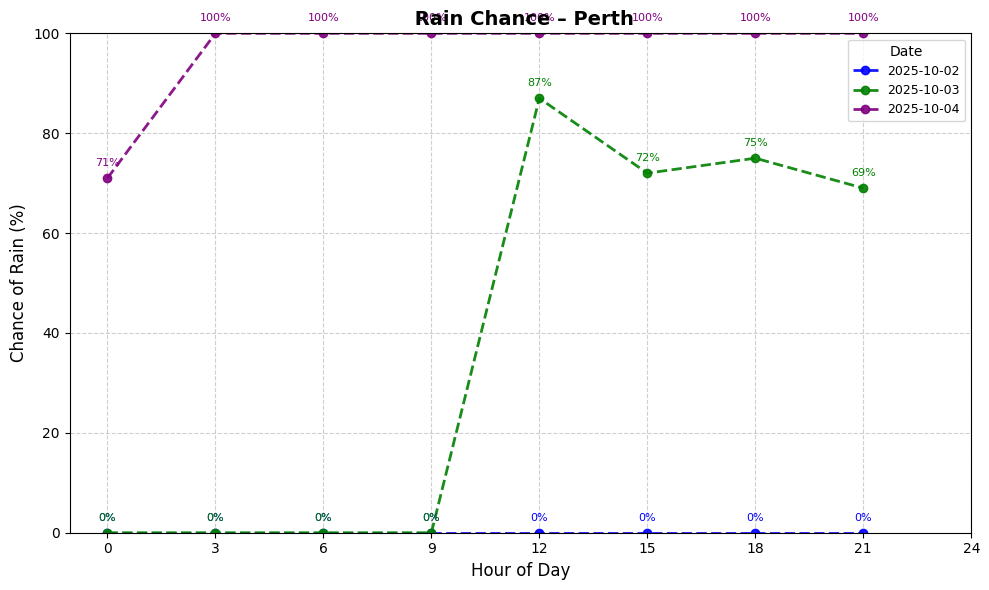

In [ ]:
sample = get_weather_data("Perth", forecast_days=5)
create_precipitation_visualisation(sample)

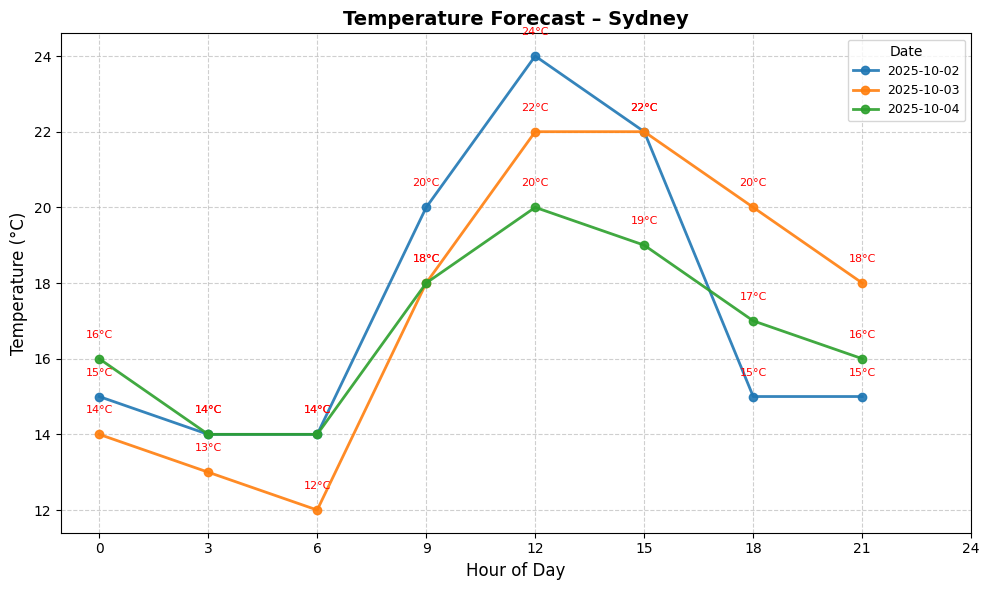

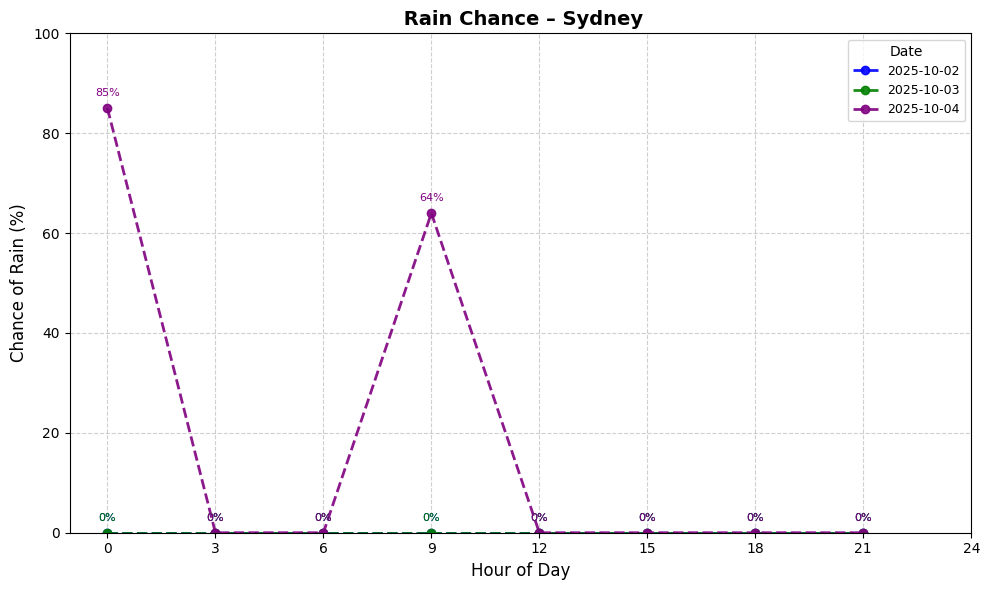

In [ ]:
sample = get_weather_data("Sydney", forecast_days=5)
create_temperature_visualisation(sample)
create_precipitation_visualisation(sample)

## 🤖 Natural Language Processing

In [ ]:
# Define parse_weather_question() and generate_weather_response() here
import re

def parse_weather_question(question):
    """
    Parse a natural language weather question.

    Args:
        question (str): User's weather-related question

    Returns:
        dict: Extracted information including location, time period, and weather attribute
    """
    q = question.lower()

    parsed = {
        "location": "Perth",
        "attribute": "temp",
        "time": "today"
    }

    if "tomorrow" in q:
        parsed["time"] = "tomorrow"

    if "rain" in q or "umbrella" in q or "precip" in q:
        parsed["attribute"] = "rain"
    elif "humidity" in q:
        parsed["attribute"] = "humidity"
    elif "temp" in q or "hot" in q or "cold" in q:
        parsed["attribute"] = "temp"

    for city in ["Perth", "Sydney", "Melbourne", "Brisbane", "Adelaide", "Darwin"]:
        if city in q:
            parsed["location"] = city.title()

    return parsed

def generate_weather_response(parsed_question, weather_data):
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Parsed question data
        weather_data (dict): Weather data

    Returns:
        str: Natural language response
    """
    attr = parsed_question["attribute"]
    time = parsed_question["time"].title()
    city = weather_data.get("location", "Unknown")


    day_idx = 0 if parsed_question["time"] == "today" else 1
    forecast = weather_data.get("forecast", [])
    if not forecast:
        return f"⚠️ Sorry, no forecast available for {city}."


    if attr == "temp":
        return (
            f"{time} in {city}, the temperature will be around "
            f"{weather_data['current']['temp_C']}°C with "
            f"{weather_data['current']['description'].lower()}."
        )

    elif attr == "rain":
        chance = forecast[day_idx].get("hourly", [{}])[0].get("chanceofrain", "0")
        chance = int(chance)


        if chance > 50:
            umbrella = "You should take an umbrella."
        elif chance > 20:
            umbrella = "Maybe take an umbrella, just in case."
        else:
            umbrella = "No umbrella needed."

        return f"{time} in {city}, the chance of rain is {chance}%. {umbrella}"

    elif attr == "humidity":
        return f"{time} in {city}, the humidity is {weather_data['current']['humidity']}%."

    elif attr == "activity":
        temp = int(weather_data['current']['temp_C'])
        humidity = int(weather_data['current']['humidity'])
        desc = weather_data['current']['description'].lower()

        if temp > 35:
            return f"{time} in {city}, it's {temp}°C — too hot for outdoor activities."
        elif "rain" in desc or "storm" in desc:
            return f"{time} in {city}, conditions are {desc}. Not ideal for outdoor activities."
        elif humidity > 80:
            return f"{time} in {city}, it's {temp}°C but very humid ({humidity}%). Outdoor activities may feel uncomfortable."
        else:
            return f"{time} in {city}, with {temp}°C and {desc}, it's a good day for outdoor activities!"

    else:
        return f"⚠️ Sorry, I couldn't understand your question about {city}."

In [21]:
# Define parse_weather_question() and generate_weather_response() here

_TIME_KEYWORDS = {
    "today": 0,
    "tomorrow": 1,
    "day after tomorrow": 2,
    "next day": 1,
    "this week": slice(0, 5),
    "next 3 days": slice(0, 3),
    "weekend": "weekend",  # special handling
}

_ATTR_KEYWORDS = {
    "temperature": ["temp", "temperature", "hot", "cold"],
    "precipitation": ["rain", "precip", "precipitation", "umbrella", "wet"],
    "wind": ["wind", "windy", "gust"],
}

_LOCATION_PATTERN = re.compile(r"in\s+([A-Za-z\-\s]+)$|for\s+([A-Za-z\-\s]+)$|at\s+([A-Za-z\-\s]+)$", re.IGNORECASE)


def parse_weather_question(question: str) -> Dict[str, Any]:
    """
    Parse a natural language weather question.

    Args:
        question (str): User's weather-related question

    Returns:
        dict: Extracted information including location, time period, and weather attribute
    """
    if not question or not isinstance(question, str):
        return {"error": "Invalid question provided."}

    q = question.strip().lower()

    # attribute detection
    attribute = None
    for attr, keys in _ATTR_KEYWORDS.items():
        if any(k in q for k in keys):
            attribute = attr
            break

    # time detection
    time_spec: Union[int, slice, str, None] = None
    for key, val in _TIME_KEYWORDS.items():
        if key in q:
            time_spec = val
            break

    # location detection: look for 'in X', 'for X', 'at X'
    location = None
    m = _LOCATION_PATTERN.search(q)
    if m:
        location = next((g for g in m.groups() if g), None)
        if location:
            location = location.strip().title()

    return {
        "raw": question,
        "location": location,
        "attribute": attribute,
        "time": time_spec,
    }

In [33]:
def show_today_weather(weather_data):
    """
    Display today's weather summary for a given location.

    Args:
        weather_data (dict): Processed weather data from get_weather_data()
    """
    current = weather_data.get("current", {})
    forecast = weather_data.get("forecast", [])
    today = forecast[0] if forecast else {}
    location = weather_data.get("location", "Unknown")

    print("\n Today's Weather in {location}")
    print("---------------------------")
    print(f"Temperature now: {current.get('temp_C', 'N/A')}°C")
    print(f"Humidity: {current.get('humidity', 'N/A')}%")
    print(f"Conditions: {current.get('description', 'Unknown')}")

    if today:
        print(f"Max Temp: {today.get('maxtempC', 'N/A')}°C")
        print(f"Min Temp: {today.get('mintempC', 'N/A')}°C")

        # Check rain chance (max across all hours today)
        rain_chance = max(
            int(h.get("chanceofrain", 0)) for h in today.get("hourly", [])
        )
        print(f"Chance of Rain: {rain_chance}%")
    else:
        print("⚠️ No forecast data available.")

In [ ]:
cities = ["Sydney"]
questions = [
    "What is the temperature today?",
    "Should I take an umbrella tomorrow?",
    "What is the humidity today?",
    "Is it a good day for outdoor activities?",
    "What is the chance of rain today?"
]

for city in cities:
    print("\n===============================")
    print(f"🌏 Testing weather for {city}")
    print("===============================\n")

    sample = get_weather_data(city, forecast_days=3)

    for q in questions:
        parsed = parse_weather_question(q)  # Removed default_location=city
        parsed["location"] = city
        print("Q:", q)
        print("Parsed:", parsed)
        print("Answer:", generate_weather_response(parsed, sample))
        print("-----")


🌏 Testing weather for Sydney

Q: What is the temperature today?
Parsed: {'location': 'Sydney', 'attribute': 'temp', 'time': 'today'}
Answer: Today in Sydney, the temperature will be around 21°C with overcast.
-----
Q: Should I take an umbrella tomorrow?
Parsed: {'location': 'Sydney', 'attribute': 'rain', 'time': 'tomorrow'}
Answer: Tomorrow in Sydney, the chance of rain is 0%. No umbrella needed.
-----
Q: What is the humidity today?
Parsed: {'location': 'Sydney', 'attribute': 'humidity', 'time': 'today'}
Answer: Today in Sydney, the humidity is 33%.
-----
Q: Is it a good day for outdoor activities?
Parsed: {'location': 'Sydney', 'attribute': 'temp', 'time': 'today'}
Answer: Today in Sydney, the temperature will be around 21°C with overcast.
-----
Q: What is the chance of rain today?
Parsed: {'location': 'Sydney', 'attribute': 'rain', 'time': 'today'}
Answer: Today in Sydney, the chance of rain is 0%. No umbrella needed.
-----


## 🧭 User Interface

In [ ]:
# Define menu functions using pyinputplus or ipywidgets here
import pyinputplus as pyip

def run_app():
    """
    WeatherWise main menu using pyinputplus (supports any city).
    """
    while True:

        city = input("\n🌏 Enter a city name (or type 'exit' to quit): ").strip()
        if city.lower() == "exit":
            print("\n👋 Goodbye! Have a Great Day 🌤️")
            break

        while True:
            choice = pyip.inputMenu(
                [
                    "Today’s Weather",
                    "Current Weather",
                    "Forecast Charts",
                    "Ask a Question",
                    "Outdoor Activities Advice",
                    "Change City",
                    "Exit"
                ],
                numbered=True
            )

            if choice == "Today’s Weather":
                data = get_weather_data(city, forecast_days=1)
                show_today_weather(data)

            elif choice == "Current Weather":
                data = get_weather_data(city, forecast_days=3)
                print(f"\n Current Weather in {city}:")
                print(f"Temperature: {data['current']['temp_C']}°C")
                print(f"Humidity: {data['current']['humidity']}%")
                print(f"Conditions: {data['current']['description']}")

            elif choice == "Forecast Charts":
                data = get_weather_data(city, forecast_days=3)
                print(f"\n Generating charts for {city}...")
                create_temperature_visualisation(data)
                create_precipitation_visualisation(data)

            elif choice == "Ask a Question":
                data = get_weather_data(city, forecast_days=3)
                q = input(f"\n Ask your weather question about {city}: ")
                parsed = parse_weather_question(q)
                parsed["location"] = city
                print( generate_weather_response(parsed, data))

            elif choice == "Outdoor Activities Advice":
                data = get_weather_data(city, forecast_days=1)
                parsed = {"location": city, "attribute": "activity", "time": "today"}
                print( generate_weather_response(parsed, data))

            elif choice == "Change City":
                break

            elif choice == "Exit":
                print("\n👋 Goodbye! Have a Great Day 🌤️")
                return

In [25]:
# Define menu functions using pyinputplus or ipywidgets here

def run_console_menu():
    """Simple console menu using pyinputplus if available, else fallback to input()."""
    global _LAST_LOCATION, _LAST_FORECAST_DAYS, _LAST_WEATHER

    def ask(prompt: str, choices: Optional[List[str]] = None) -> str:
        if pyip and choices:
            return pyip.inputMenu(choices, prompt=prompt + "\n", numbered=True)
        elif pyip:
            return pyip.inputStr(prompt)
        else:
            # basic fallback
            return input(prompt + (f" ({'/'.join(choices)})" if choices else "") + ": ")

    # Start with asking for a location
    current_location = ask("Enter a city name")

    while True:
        choice = ask(prompt=f"Choose an option for {current_location}", choices=[
                    "Today’s Weather",
                    "Current Weather",
                    "Forecast Charts",
                    "Ask a Question",
                    "Outdoor Activities Advice",
                    "Change City",
                    "Exit"
        ])

        if choice == "Today’s Weather":
            data = get_weather_data(current_location, forecast_days=5)
            if data.get("error"):
                print("Error:", data["error"])
            else:
                show_today_weather(data) # Assuming show_today_weather exists

        elif choice == "Current Weather":
            data = get_weather_data(current_location, forecast_days=1) # Current weather is usually part of day 1 data
            if data.get("error"):
                print("Error:", data["error"])
            elif data.get("current"):
                print(f"\n Current Weather in {current_location}:")
                print(f"Temperature: {data['current'].get('temp_C', 'N/A')}°C")
                print(f"Humidity: {data['current'].get('humidity', 'N/A')}%")
                print(f"Conditions: {data['current'].get('description', 'Unknown')}")
            else:
                 print(f" Current weather data not available for {current_location}.")


        elif choice == "Forecast Charts":
            days_str = ask("Forecast days (1-5)", choices=[str(i) for i in range(1, 6)]) or '5'
            try:
                days = max(1, min(int(days_str), 5))
            except Exception:
                days = 5
            data = get_weather_data(current_location, forecast_days=days)
            if data.get("error"):
                print("Error:", data["error"])
            else:
                print(f"\n Generating charts for {current_location}...")
                create_temperature_visualisation(data) # Assuming these functions exist
                create_precipitation_visualisation(data)


        elif choice == "Ask a Question":
            q = ask(f"Ask your weather question about {current_location}: ")
            data = get_weather_data(current_location, forecast_days=5) # Fetch enough data for questions
            if data.get("error"):
                 print("Error:", data["error"])
            else:
                parsed = parse_weather_question(q) # Assuming parse_weather_question exists
                parsed["location"] = current_location # Ensure correct location
                print("Answer:", generate_weather_response(parsed, data)) # Assuming generate_weather_response exists


        elif choice == "Outdoor Activities Advice":
            data = get_weather_data(current_location, forecast_days=1) # Need today's conditions
            if data.get("error"):
                 print("Error:", data["error"])
            else:
                parsed = {"location": current_location, "attribute": "activity", "time": "today"}
                print( generate_weather_response(parsed, data))


        elif choice == "Change City":
            current_location = ask("Enter a new city name")
            _LAST_LOCATION = current_location # Update global state if needed


        elif choice == "Exit":
            print("\n👋 Goodbye! Have a Great Day 🌤️")
            return

In [34]:
run_console_menu()

Enter a city namePerth
Choose an option for Perth
1. Today’s Weather
2. Current Weather
3. Forecast Charts
4. Ask a Question
5. Outdoor Activities Advice
6. Change City
7. Exit
1

 Today's Weather in {location}
---------------------------
Temperature now: 22°C
Humidity: 46%
Conditions: Unknown
⚠️ No forecast data available.
Choose an option for Perth
1. Today’s Weather
2. Current Weather
3. Forecast Charts
4. Ask a Question
5. Outdoor Activities Advice
6. Change City
7. Exit
5
Currently in Perth: 22°C, Sunny.
Choose an option for Perth
1. Today’s Weather
2. Current Weather
3. Forecast Charts
4. Ask a Question
5. Outdoor Activities Advice
6. Change City
7. Exit
4
Ask your weather question about Perth: hot
Answer: Right now in Perth: 22°C, Sunny. Feels like 24°C.
Choose an option for Perth
1. Today’s Weather
2. Current Weather
3. Forecast Charts
4. Ask a Question
5. Outdoor Activities Advice
6. Change City
7. Exit
cold
'cold' is not a valid choice.
Choose an option for Perth
1. Today’s W

## 🧩 Main Application Logic

In [33]:
# Tie everything together here
def generate_weather_response(parsed_question, weather_data):
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Parsed question data
        weather_data (dict): Weather data

    Returns:
        str: Natural language response
    """

    attr = parsed_question["attribute"]
    time = parsed_question["time"].title()
    city = parsed_question["location"]

    # Today = 0, Tomorrow = 1 (fallback if forecast not enough days)
    day_idx = 0 if parsed_question["time"] == "today" else 1
    forecast = weather_data.get("forecast", [])

    if not forecast:
        return f"⚠️ Sorry, no forecast available for {city}."

    # 🌡️ Temperature
    if attr == "temp":
        return (
            f"{time} in {city}, the temperature will be around "
            f"{weather_data['current']['temp_C']}°C with "
            f"{weather_data['current']['description'].lower()}."
        )

    # 🌧️ Rain / Umbrella advice
    elif attr == "rain":
        chance = int(forecast[min(day_idx, len(forecast)-1)].get("hourly", [{}])[0].get("chanceofrain", "0"))
        if chance > 50:
            umbrella = "You should take an umbrella."
        elif chance > 20:
            umbrella = "Maybe take an umbrella, just in case."
        else:
            umbrella = "No umbrella needed."
        return f"{time} in {city}, the chance of rain is {chance}%. {umbrella}"

    # 💧 Humidity
    elif attr == "humidity":
        return f"{time} in {city}, the humidity is {weather_data['current']['humidity']}%."

    # 🏃 Outdoor Activities
    elif attr == "activity":
        temp = int(weather_data['current']['temp_C'])
        humidity = int(weather_data['current']['humidity'])
        desc = weather_data['current']['description'].lower()

        if temp > 35:
            return f"{time} in {city}, it's {temp}°C — too hot for outdoor activities."
        elif "rain" in desc or "storm" in desc:
            return f"{time} in {city}, conditions are {desc}. Not ideal for outdoor activities."
        elif humidity > 80:
            return f"{time} in {city}, it's {temp}°C but very humid ({humidity}%). Outdoor activities may feel uncomfortable."
        else:
            return f"{time} in {city}, with {temp}°C and {desc}, it's a good day for outdoor activities!"

    # ⚠️ Fallback if not understood
    else:
        return f"⚠️ Sorry, I couldn't understand your question about {city}."

In [31]:
# Tie everything together here

def generate_weather_response(parsed_question: Dict[str, Any], weather_data: Dict[str, Any]) -> str:
    """
    Generate a natural language response to a weather question.

    Args:
        parsed_question (dict): Parsed question data
        weather_data (dict): Weather data

    Returns:
        str: Natural language response
    """
    if parsed_question.get("error"):
        return parsed_question["error"]
    if weather_data.get("error"):
        return weather_data["error"]

    location = weather_data.get("location") or parsed_question.get("location") or "the selected location"
    current = weather_data.get("current", {})
    daily = weather_data.get("daily", [])

    attribute = parsed_question.get("attribute")
    time_spec = parsed_question.get("time")

    def format_day(d: Dict[str, Any]) -> str:
        date = d.get("date", "")
        desc = (d.get("hourly", [{}])[0].get("weatherDesc") or [{"value": ""}])[0].get("value", "")
        return f"{date} ({desc})"

    if attribute == "temperature":
        # If today requested or unspecified, use current
        if time_spec in (None, 0):
            t = current.get("temp_C")
            feels = current.get("FeelsLikeC") or current.get("FeelsLikeC")
            desc = (current.get("weatherDesc") or [{"value": ""}])[0].get("value", "")
            if t is not None:
                return f"Right now in {location}: {t}°C, {desc}. Feels like {feels}°C."
        # Otherwise use daily forecast
        if isinstance(time_spec, int) and 0 <= time_spec < len(daily):
            d = daily[time_spec]
            return (
                f"In {location} on {d.get('date')}: min {d.get('mintempC')}°C, max {d.get('maxtempC')}°C."
            )
        if isinstance(time_spec, slice):
            parts = []
            for d in daily[time_spec]:
                parts.append(f"{d.get('date')}: {d.get('mintempC')}–{d.get('maxtempC')}°C")
            if parts:
                return f"Temperature forecast for {location}: " + "; ".join(parts)

    if attribute == "precipitation":
        if isinstance(time_spec, int) and 0 <= time_spec < len(daily):
            d = daily[time_spec]
            mm = d.get("totalPrecipMM")
            return f"Expected precipitation in {location} on {d.get('date')}: {mm} mm."
        if time_spec in (None, 0):
            # Try current precipitation
            precip_mm = current.get("precipMM")
            if precip_mm is not None:
                return f"Right now in {location}, precipitation is {precip_mm} mm."
        if isinstance(time_spec, slice):
            parts = []
            for d in daily[time_spec]:
                parts.append(f"{d.get('date')}: {d.get('totalPrecipMM', 0)} mm")
            if parts:
                return f"Precipitation forecast for {location}: " + "; ".join(parts)

    if attribute == "wind":
        if time_spec in (None, 0):
            spd = current.get("windspeedKmph")
            dirp = current.get("winddir16Point")
            if spd is not None:
                return f"Current wind in {location}: {spd} km/h {dirp or ''}."

    # Fallback generic summary
    if current:
        desc = (current.get("weatherDesc") or [{"value": ""}])[0].get("value", "")
        t = current.get("temp_C")
        return f"Currently in {location}: {t}°C, {desc}."

    return "I'm unable to summarise the weather from the provided data."

In [34]:
sample = get_weather_data("Perth", forecast_days=5)

questions = [
   "What is the temperature today?",
    "Should I take an umbrella tomorrow?",
    "What is the humidity today?",
    "Is it a good day for outdoor activities?",
    "What is the chance of rain today?"
]

for q in questions:
    parsed = parse_weather_question(q)
    print("Q:", q)
    print("Parsed:", parsed)
    print("Answer:", generate_weather_response(parsed, sample))
    print("-----")

NameError: name 'parse_weather_question' is not defined

## 🧪 Testing and Examples

In [35]:

print("🔎 Testing Weather Data Fetch...")
sample = get_weather_data("Perth", forecast_days=3)

print("Location:", sample["location"])
print("Current:", sample["current"])
print("Forecast length:", len(sample["forecast"]))

# Test Temperature Chart
print("📊 Testing Temperature Visualisation...")
create_temperature_visualisation(sample)

# Test Precipation Chart

print("🌧️ Testing Precipitation Visualisation...")
create_precipitation_visualisation(sample)

# Test Natural Language processing
print("🤖 Testing Q&A...")
questions = [
  "What is the temperature today?",
    "Should I take an umbrella tomorrow?",
    "What is the humidity today?",
    "Is it a good day for outdoor activities?",
    "What is the chance of rain today?"
]

for q in questions:
    parsed = parse_weather_question(q)
    print("\nQ:", q)
    print("Parsed:", parsed)
    print("Answer:", generate_weather_response(parsed, sample))

# Test Menu System
print("🖥️ Testing Menu (manual interaction required)...")
# Run the interactive menu app
run_app()# Include sample input/output for each function
# Test the Weather Data

🔎 Testing Weather Data Fetch...
Location: Perth
Current: {'FeelsLikeC': '24', 'FeelsLikeF': '76', 'cloudcover': '25', 'humidity': '46', 'localObsDateTime': '2025-10-15 02:52 PM', 'observation_time': '06:52 AM', 'precipInches': '0.0', 'precipMM': '0.0', 'pressure': '1014', 'pressureInches': '30', 'temp_C': '22', 'temp_F': '72', 'uvIndex': '8', 'visibility': '10', 'visibilityMiles': '6', 'weatherCode': '113', 'weatherDesc': [{'value': 'Sunny'}], 'weatherIconUrl': [{'value': ''}], 'winddir16Point': 'WSW', 'winddirDegree': '243', 'windspeedKmph': '18', 'windspeedMiles': '11'}


KeyError: 'forecast'

Fetch OK


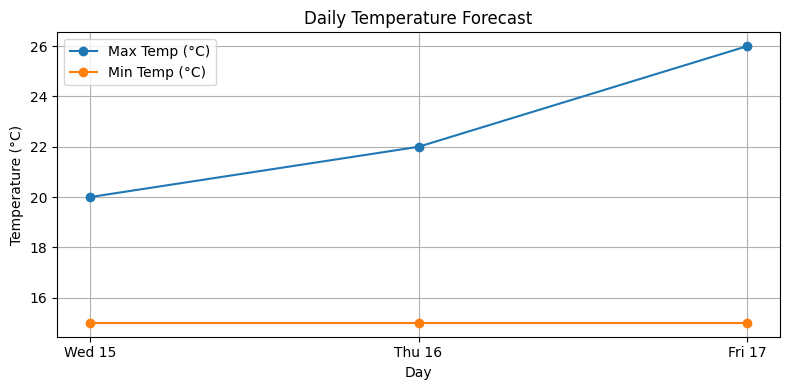

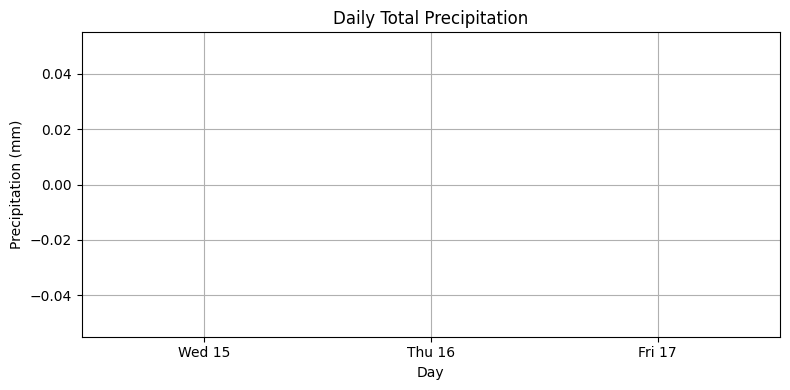

Parsed: {'raw': 'Will it rain tomorrow in Perth?', 'location': None, 'attribute': 'precipitation', 'time': 1}
Response: Expected precipitation in Perth on 2025-10-16: None mm.
Enter a city nameMelbourne
Choose an option for Melbourne
1. Today’s Weather
2. Current Weather
3. Forecast Charts
4. Ask a Question
5. Outdoor Activities Advice
6. Change City
7. Exit
2

 Current Weather in Melbourne:
Temperature: 16°C
Humidity: 63%
Conditions: Unknown
Choose an option for Melbourne
1. Today’s Weather
2. Current Weather
3. Forecast Charts
4. Ask a Question
5. Outdoor Activities Advice
6. Change City
7. Exit

Blank values are not allowed.
Choose an option for Melbourne
1. Today’s Weather
2. Current Weather
3. Forecast Charts
4. Ask a Question
5. Outdoor Activities Advice
6. Change City
7. Exit
3
Forecast days (1-5)
1. 1
2. 2
3. 3
4. 4
5. 5
5

 Generating charts for Melbourne...


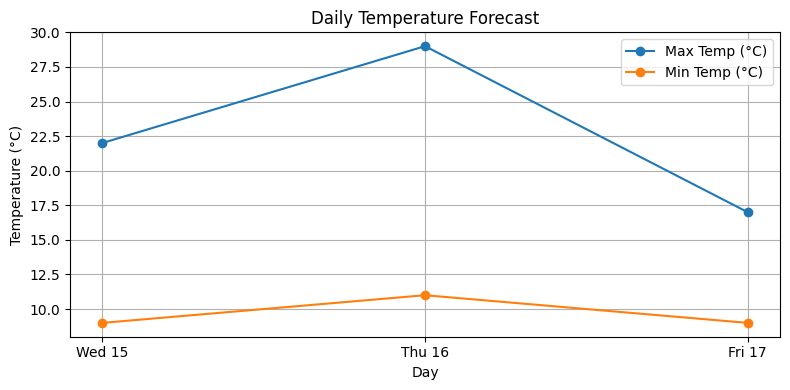

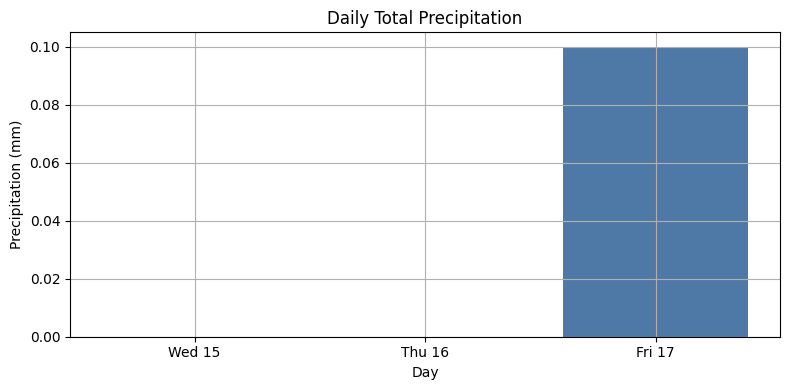

Choose an option for Melbourne
1. Today’s Weather
2. Current Weather
3. Forecast Charts
4. Ask a Question
5. Outdoor Activities Advice
6. Change City
7. Exit
7

👋 Goodbye! Have a Great Day 🌤️


In [37]:
# Include sample input/output for each function

# 1) Minimal smoke test for data fetch (uses mock fallback via with_metadata)
try:
    demo_data = get_weather_data("Perth", forecast_days=5)
    print("Fetch OK" if not demo_data.get("error") else f"Fetch error: {demo_data['error']}")
except Exception as e:
    print("Fetch raised exception:", e)

# 2) Visualisation smoke test (these will show plots in notebook if data available)
if demo_data and not demo_data.get("error"):
    _ = create_temperature_visualisation(demo_data)
    _ = create_precipitation_visualisation(demo_data)

# 3) NLP + response test
parsed = parse_weather_question("Will it rain tomorrow in Perth?")
print("Parsed:", parsed)
print("Response:", generate_weather_response(parsed, demo_data if demo_data else {}))

# 4) Optional: run the console menu interactively
run_console_menu()  # Uncomment to try interactive flow in a console-capable environment

## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.